In [3]:
!pip install tweet-preprocessor

In [4]:
!unzip glove.6B.100d.txt.zip

Archive:  glove.6B.100d.txt.zip
replace glove.6B.100d.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [66]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt

from TextProcessor import *
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, GRU, Dropout, SimpleRNN
from sklearn.model_selection import KFold
from keras import backend as K 
from tensorflow.python.client import device_lib
from sklearn.metrics import classification_report, confusion_matrix


In [6]:
train_data = pd.read_csv(os.path.join("train_data.csv"))
test_data = pd.read_csv(os.path.join("test_data.csv"))

X_train, y_train = train_data['Text'].to_numpy(), train_data['oh_label'].to_numpy()
X_test, y_test = test_data['Text'].to_numpy(), test_data['oh_label'].to_numpy()

In [7]:
tp = TextProcessor(remove_punctuation=True, 
                   remove_stop_word=True, 
                   min_word_size=2, 
                   special_token_method=SpecialTokenMethod.PREPROCESS)

In [8]:
X_train = tp.fit_transform(X_train)
X_test = tp.fit_transform(X_test)

In [9]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [10]:
vocab_size = len(tokenizer.word_index) + 1

maxlen = 40

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [11]:
from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open('glove.6B.100d.txt', encoding="utf8")

In [12]:
for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [13]:
embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [74]:
def create_model():
    model = Sequential()
    model.add(Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False))
    model.add(GRU(16, return_sequences=True))
    model.add(Dropout(0.5))
    model.add(GRU(8, return_sequences=False))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    
    return model

Epoch 1/10
85/85 [==============================] - 12s 67ms/step - loss: 0.6948 - acc: 0.6036 - val_loss: 0.5970 - val_acc: 0.6840
Epoch 2/10
85/85 [==============================] - 5s 59ms/step - loss: 0.6269 - acc: 0.6657 - val_loss: 0.5748 - val_acc: 0.7088
Epoch 3/10
85/85 [==============================] - 5s 60ms/step - loss: 0.5811 - acc: 0.7187 - val_loss: 0.5284 - val_acc: 0.7515
Epoch 4/10
85/85 [==============================] - 5s 59ms/step - loss: 0.5558 - acc: 0.7371 - val_loss: 0.5180 - val_acc: 0.7589
Epoch 5/10
85/85 [==============================] - 5s 59ms/step - loss: 0.5538 - acc: 0.7348 - val_loss: 0.5145 - val_acc: 0.7630
Epoch 6/10
85/85 [==============================] - 5s 60ms/step - loss: 0.5291 - acc: 0.7623 - val_loss: 0.5030 - val_acc: 0.7645
Epoch 7/10
85/85 [==============================] - 5s 60ms/step - loss: 0.5062 - acc: 0.7762 - val_loss: 0.5046 - val_acc: 0.7593
Epoch 8/10
85/85 [==============================] - 5s 61ms/step - loss: 0.5061 - 

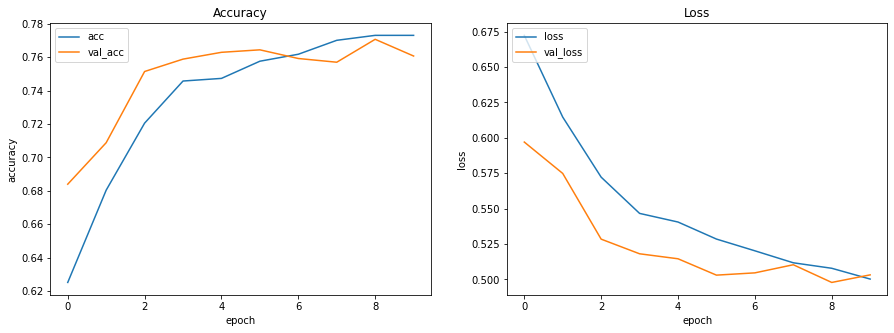

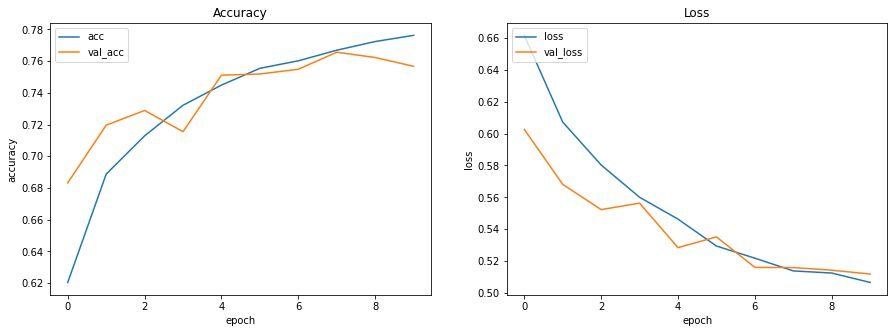

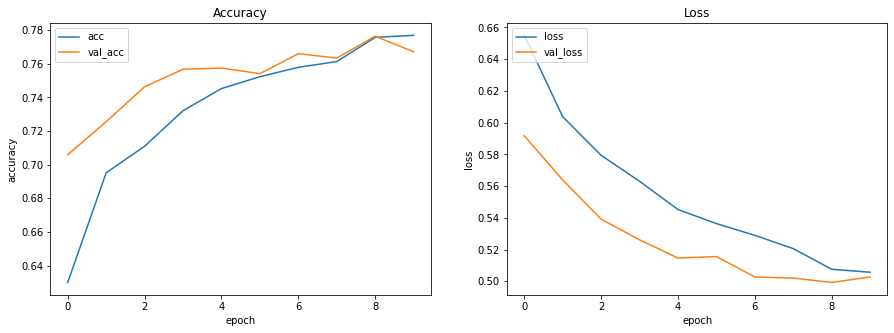

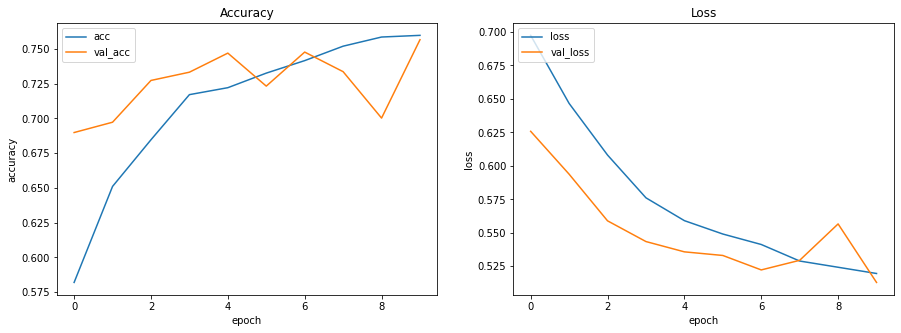

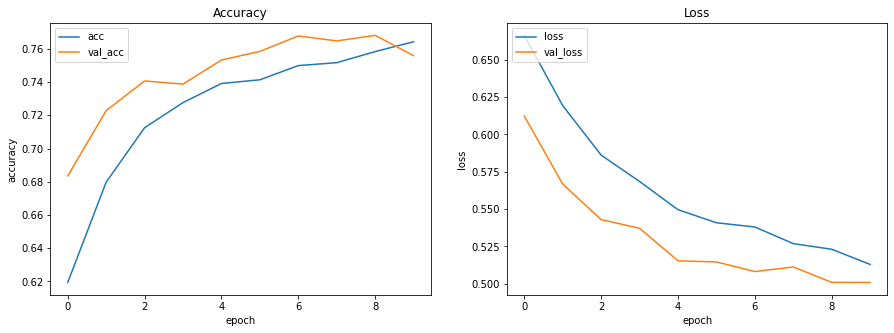

In [68]:
NB_FOLD=5
kf = KFold(n_splits=NB_FOLD)

i = 0

for train_index, validation_index in kf.split(X_train, y_train):
    x_tr = X_train[train_index]
    y_tr = y_train[train_index]
    
    x_te = X_train[validation_index]
    y_te = y_train[validation_index]
    
    model = create_model()
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
    
    history = model.fit(x_tr, 
                        y_tr, 
                        batch_size=128, 
                        epochs=10, 
                        validation_data=(x_te, y_te))
    
    model.save(os.path.join("saved_models","dl", f"model_{i}.h5"))

    a = model.evaluate(x_te, y_te)
    print(a)

    fig, axes = plt.subplots(1,2, figsize=(15,5))
    # summarize history for accuracy\n"

    axes[0].plot(history.history['acc'])
    axes[0].plot(history.history['val_acc'])
    axes[0].set_title('Accuracy')
    axes[0].set_ylabel('accuracy')
    axes[0].set_xlabel('epoch')
    axes[0].legend(['acc', 'val_acc'], loc='upper left')
    
    axes[1].plot(history.history['loss'])
    axes[1].plot(history.history['val_loss'])
    axes[1].set_title('Loss')
    axes[1].set_ylabel('loss')
    axes[1].set_xlabel('epoch')
    axes[1].legend(['loss', 'val_loss'], loc='upper left')
    
    i+=1

Epoch 1/10
211/211 [==============================] - 5s 10ms/step - loss: 0.6541 - acc: 0.6763 - val_loss: 0.6250 - val_acc: 0.6825
Epoch 2/10
211/211 [==============================] - 1s 7ms/step - loss: 0.6397 - acc: 0.6735 - val_loss: 0.6254 - val_acc: 0.6825
Epoch 3/10
211/211 [==============================] - 1s 7ms/step - loss: 0.6326 - acc: 0.6795 - val_loss: 0.6253 - val_acc: 0.6825
Epoch 4/10
211/211 [==============================] - 1s 7ms/step - loss: 0.6315 - acc: 0.6828 - val_loss: 0.4743 - val_acc: 0.7958
Epoch 5/10
211/211 [==============================] - 1s 7ms/step - loss: 0.4822 - acc: 0.7925 - val_loss: 0.4210 - val_acc: 0.8205
Epoch 6/10
211/211 [==============================] - 1s 7ms/step - loss: 0.4408 - acc: 0.8125 - val_loss: 0.4057 - val_acc: 0.8279
Epoch 7/10
211/211 [==============================] - 1s 7ms/step - loss: 0.4140 - acc: 0.8265 - val_loss: 0.4022 - val_acc: 0.8249
Epoch 8/10
211/211 [==============================] - 1s 7ms/step - loss: 0

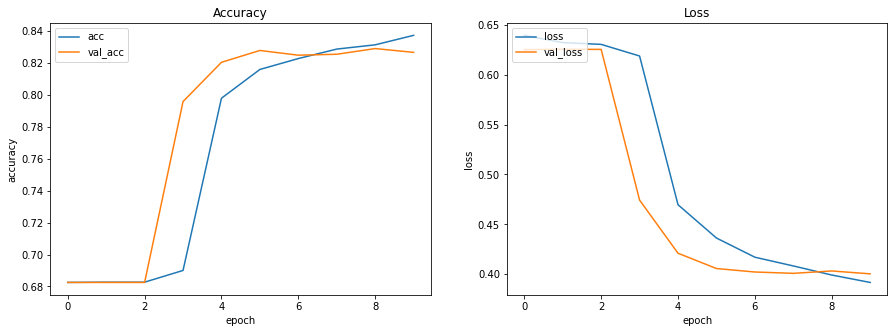

In [75]:
model = create_model()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

history = model.fit(X_train, 
                    y_train, 
                    batch_size=64, 
                    epochs=10, 
                    validation_data=(X_test, y_test))

model.save(os.path.join("saved_models","dl", f"model_final.h5"))

a = model.evaluate(X_test, y_test)
print(a)

fig, axes = plt.subplots(1,2, figsize=(15,5))
# summarize history for accuracy\n"

axes[0].plot(history.history['acc'])
axes[0].plot(history.history['val_acc'])
axes[0].set_title('Accuracy')
axes[0].set_ylabel('accuracy')
axes[0].set_xlabel('epoch')
axes[0].legend(['acc', 'val_acc'], loc='upper left')

axes[1].plot(history.history['loss'])
axes[1].plot(history.history['val_loss'])
axes[1].set_title('Loss')
axes[1].set_ylabel('loss')
axes[1].set_xlabel('epoch')
axes[1].legend(['loss', 'val_loss'], loc='upper left')

In [73]:
predictions = np.where(model.predict(X_test) > 0.5, 1, 0)

print(confusion_matrix(y_test,predictions))
print(classification_report(y_test, predictions))

[[2098  202]
 [ 373  697]]
              precision    recall  f1-score   support

         0.0       0.85      0.91      0.88      2300
         1.0       0.78      0.65      0.71      1070

    accuracy                           0.83      3370
   macro avg       0.81      0.78      0.79      3370
weighted avg       0.83      0.83      0.83      3370

